# Create test dataframe

In [1]:
import numpy as np
import pandas as pd
from time import sleep
from os import environ
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from indicators.indicators import IndicatorFactory

debug = False
# Set environment variable
environ["ENV"] = "development"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'ETHUSDT': ['5m']}}
# Get configs
configs = ConfigFactory.factory(environ).configs

    
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange)
    tickers = exchanges[exchange]
    for ticker in tickers:
        timeframes = tickers[ticker]
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            # # If all cryptocurrencies signal stat is in dataframe dict - get it, else create new
            # stat = dfs.get('stat', pd.DataFrame())
            # If cryptocurrency dataframe and it's signal stat is in dataframe dict - get it,
            # else - create the new ones
            df = dfs.get(ticker, dict()).get(timeframe, pd.DataFrame())
            # If dataframe is empty - get all available data to fill it,
            # else - just get necessary for update data
            if df.shape == (0, 0):
                interval = configs['Interval']['creation_interval']
            else:
                interval = configs['Interval']['update_interval']
            # Write data to the dataframe
            if debug:
                df = pd.read_pickle('debug.pkl')
            else:
                df = exchange_api.get_data(df, ticker, timeframe, interval)
            # Create indicator list
            indicator_list = configs['Indicator_list']
            indicators = list()
            for indicator in indicator_list:
                indicators.append(IndicatorFactory.factory(indicator, configs))
            # Write indicators to dataframe
            df = exchange_api.add_indicator_data(df, indicators, ticker, timeframe)
            # Update dataframe dict
            if ticker not in dfs:
                dfs[ticker] = dict()
            dfs[ticker][timeframe] = df
            # Get signal
            fs = FindSignal(configs)
            points = fs.find_signal(df)
            # Write statistics
            ss = SignalStat()
            dfs = ss.write_stat(dfs, ticker, timeframe, points)
            ss.calculate_total_stat(dfs, 'buy')

Exchange is Binance, ticker is ETHUSDT, timeframe is 5m
0
1000


## Plot STOCH values

79.58799278850859 45
11
14


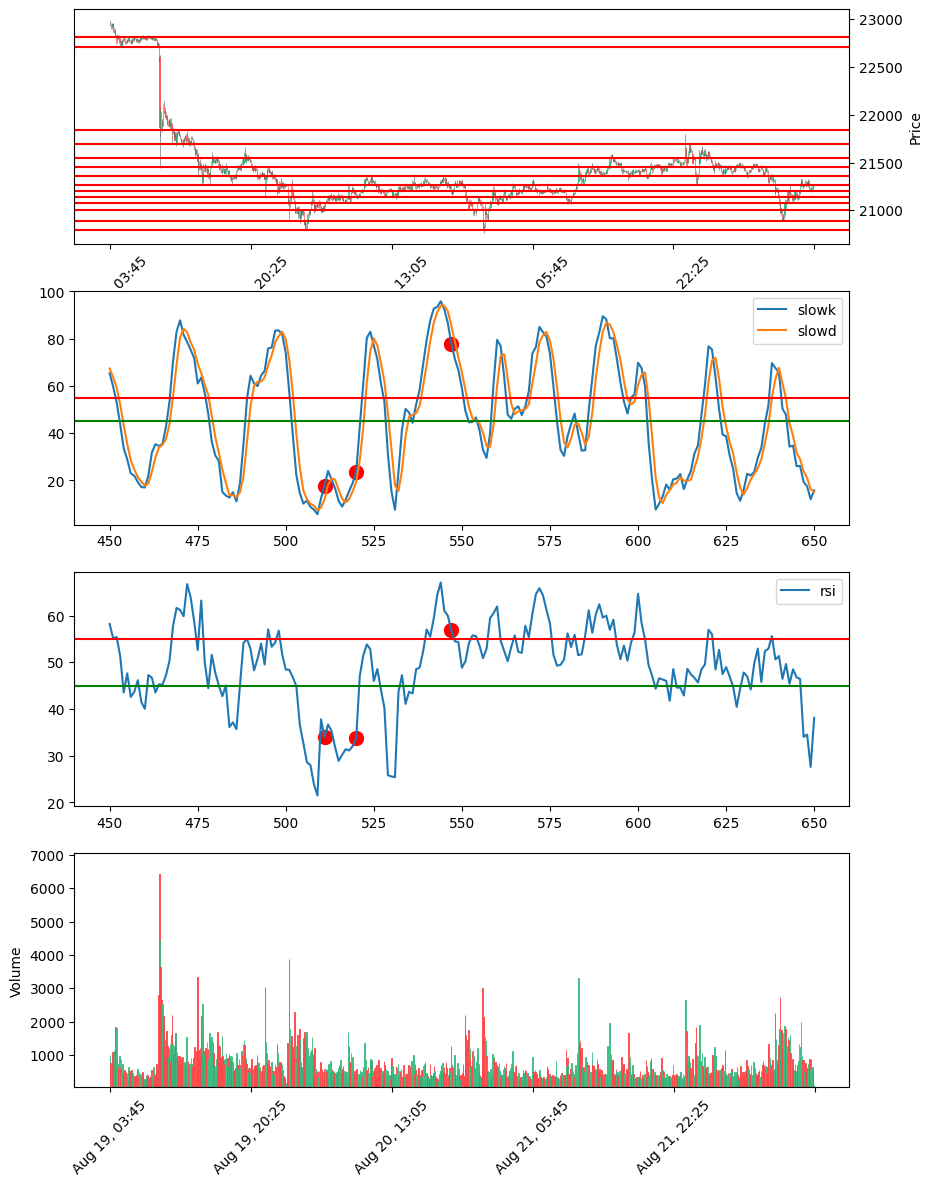

In [1]:
from os import environ
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signals.find_signal import SignalFactory

pd.set_option('display.max_rows', 500)

# Set environment variable
environ["ENV"] = "development"

configs = ConfigFactory.factory(environ).configs
df = pd.read_pickle('BTCUSDT_5m.pkl')
fs = FindSignal(configs)
points = fs.find_signal(df)

# save signal points for visualization
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    scatter_stoch_points.append((point[0], df.loc[point[0], 'stoch_slowk']))
    scatter_rsi_points.append((point[0], df.loc[point[0], 'rsi']))
    
# subplots for STOCH and RSI
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 14))

# plot candles
ohlc = df.loc[:, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo', volume=ax4)

# plot STOCH
ax2.plot(df.loc[450:650, 'stoch_slowk'])
ax2.plot(df.loc[450:650, 'stoch_slowd'])
# show bounders
ax2.axhline(y=45, color='g', linestyle='-')
ax2.axhline(y=55, color='r', linestyle='-')
leg = ax2.legend(['slowk', 'slowd'])

for point in scatter_stoch_points:
    if 450 < point[0] < 650:
        ax2.scatter(point[0], point[1], s=100, color='red')

# plot RSI
ax3.plot(df.loc[450:650, 'rsi'])
ax3.axhline(y=45, color='g', linestyle='-')
ax3.axhline(y=55, color='r', linestyle='-')
leg = ax3.legend(['rsi'])

for point in scatter_rsi_points:
    if 450 < point[0] < 650:
        ax3.scatter(point[0], point[1], s=100, color='red')

df['high_roll'] = df['high'].rolling(3).mean()
df['low_roll'] = df['low'].rolling(3).mean()
srs = SignalFactory.factory('SUP_RES', configs)
levels = srs.find_levels(df)
print(len(levels))
for level in levels:
    # show bounders
    if df.loc[:, 'low'].min() <= level[0] <= df.loc[:, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-')